# Data Exploratory Notebook
### Rhea Soil Nutrient Prediction Challenge

Start here:

Looking at distribution of train & test data
* location
* depth
* soil nutrients


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import os

from pyexpat import features

from src.config import DATA_DIR, ZINDI_DATA_DIR, TARGETS, OUTPUT_DIR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
train_df = pd.read_csv(os.path.join(ZINDI_DATA_DIR, "Train.csv"))
test_df = pd.read_csv(os.path.join(ZINDI_DATA_DIR, "TestSet.csv"))
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Column names: {train_df.columns}")

# merge dfs
train_df["dataset"] = "train"
test_df["dataset"] = "test"
df = pd.concat([train_df, test_df]).reset_index()

Train data shape: (44298, 25)
Test data shape: (6070, 17)
Column names: Index(['ID', 'Longitude', 'Latitude', 'start_date', 'end_date',
       'horizon_lower', 'horizon_upper', 'Depth_cm', 'Al', 'B', 'Ca',
       'C_organic', 'C_total', 'Cu', 'electrical_conductivity', 'Fe', 'Mg',
       'Mn', 'N', 'ph', 'P', 'K', 'Na', 'S', 'Zn'],
      dtype='str')


## Geographic distribution & measurement depth

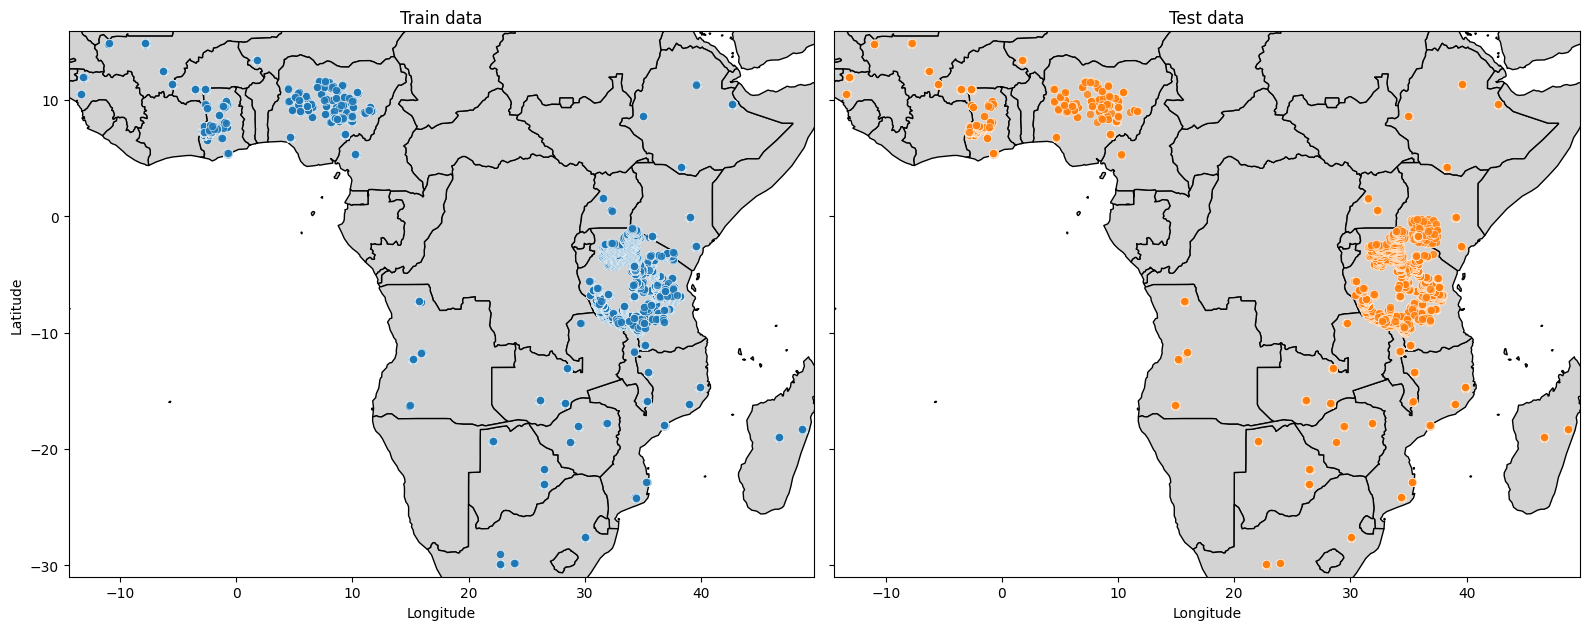

In [3]:
uniq_depths = df.Depth_cm.unique()

world_img = gpd.read_file(
    os.path.join(DATA_DIR, "maps", "global_map", "CNTR_RG_20M_2024_4326.shp")
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

datasets = ["train", "test"]
colors = {"train": "tab:blue", "test": "tab:orange"}

for ax, dataset in zip(axes, datasets):
    # base map
    world_img.plot(ax=ax, color="lightgrey", edgecolor="black")

    ax.set_xlim(df["Longitude"].min() - 1, df["Longitude"].max() + 1)
    ax.set_ylim(df["Latitude"].min() - 1, df["Latitude"].max() + 1)

    for depth in uniq_depths:
        mask = (df.Depth_cm == depth) & (df["dataset"] == dataset)
        ax.scatter(
            df.loc[mask, "Longitude"],
            df.loc[mask, "Latitude"],
            s=35,
            alpha=0.8,
            color=colors[dataset],
            edgecolor="white",
            linewidth=0.4,
        )

    ax.set_title(f"{dataset.capitalize()} data")
    ax.set_xlabel("Longitude")

axes[0].set_ylabel("Latitude")

# legend for dataset (color)
legend_dataset = [
    Line2D([0], [0], marker="o", color="w",
           label=label, markerfacecolor=color, markersize=8)
    for label, color in colors.items()
]

plt.tight_layout()
plt.show()


In [4]:
df.groupby(["dataset", "Depth_cm"]).size()

dataset  Depth_cm
test     0-20         3795
         20-50        2275
train    0-20        24078
         20-50       20220
dtype: int64

Both location and soil depth have very similar distributions across the two dataset, while there are slightly more top-soil measurements.

# Soil nutrient distribution
The target variables capture the core soil nutrient concentrations we aim to predict.
They are essential indicators of soil fertility, plant health, and nutrient balance, so understanding their distributions help frame expected ranges and spatial variability.

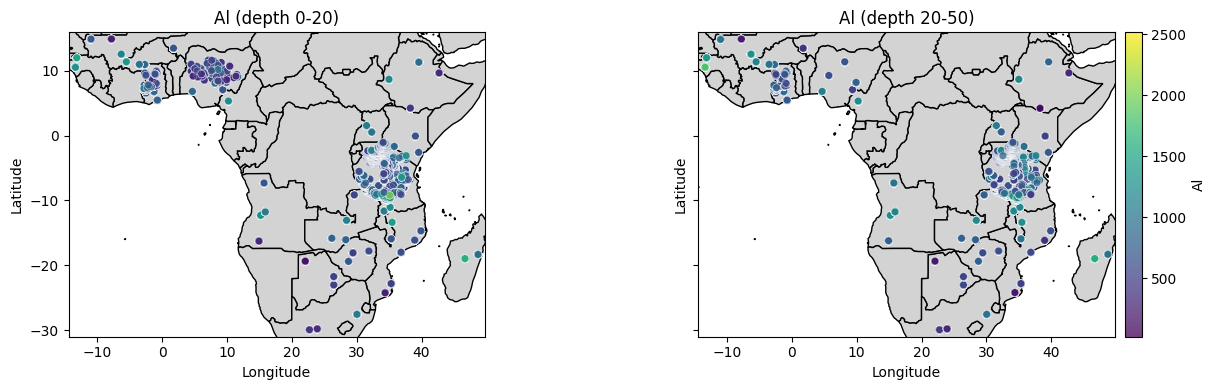

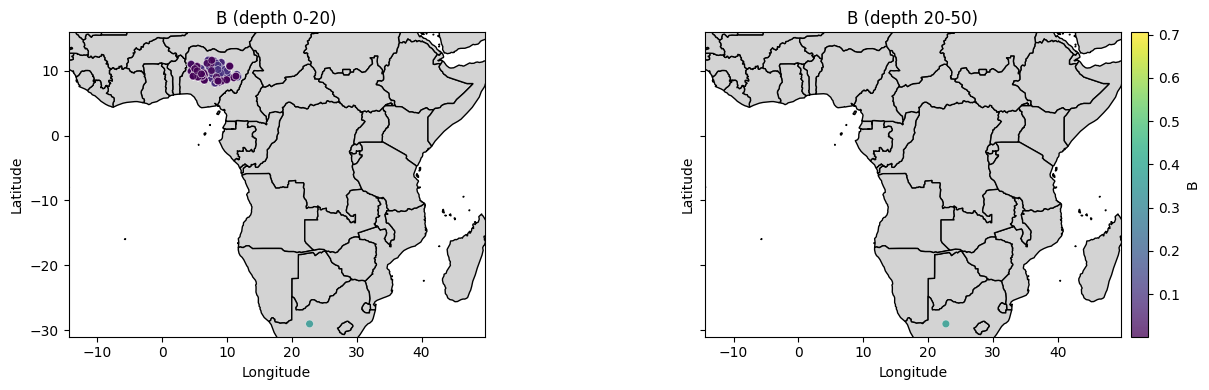

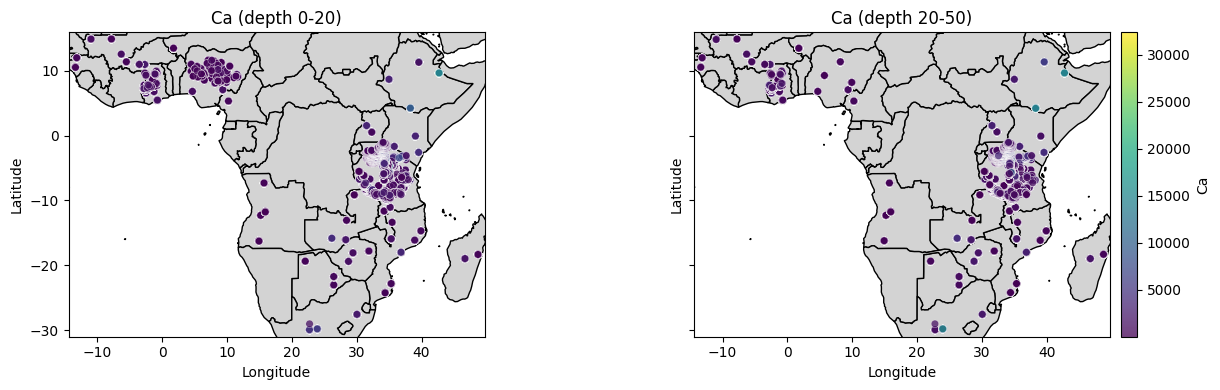

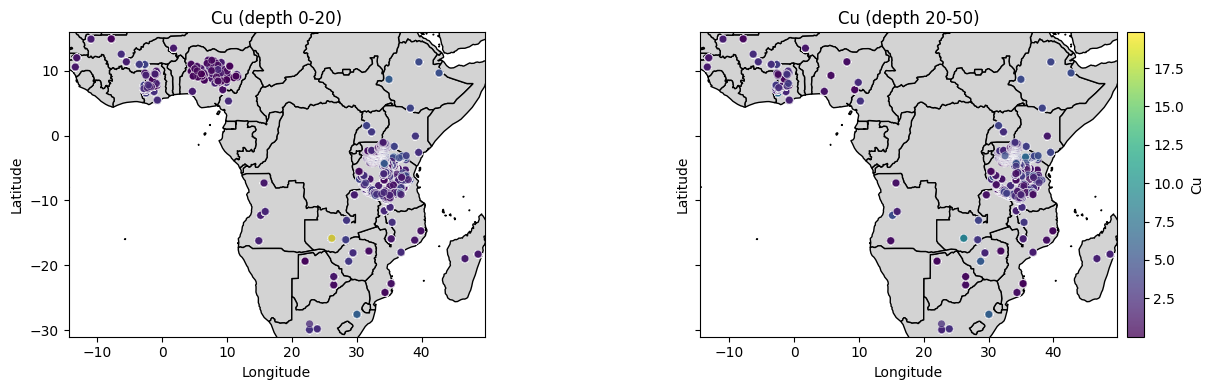

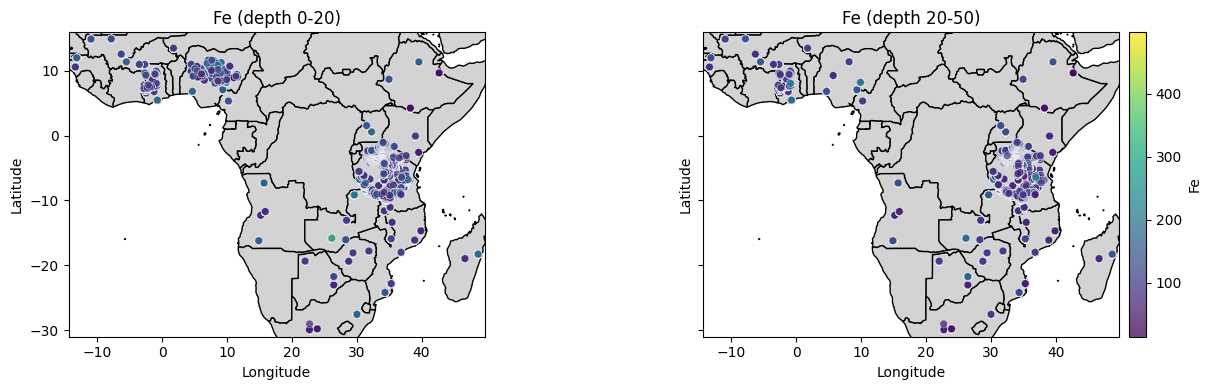

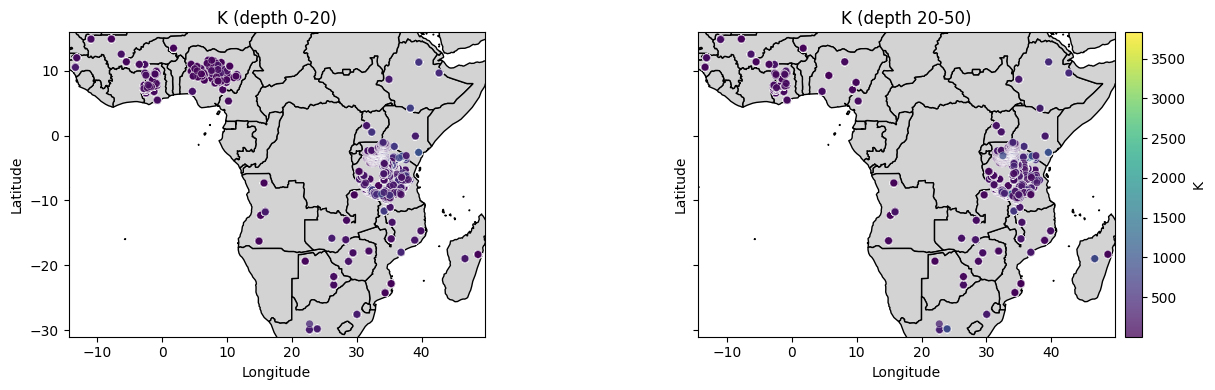

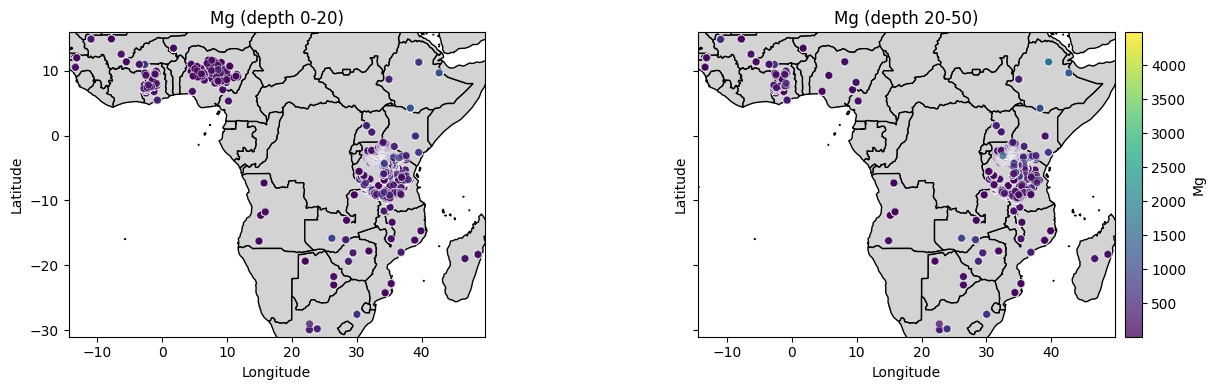

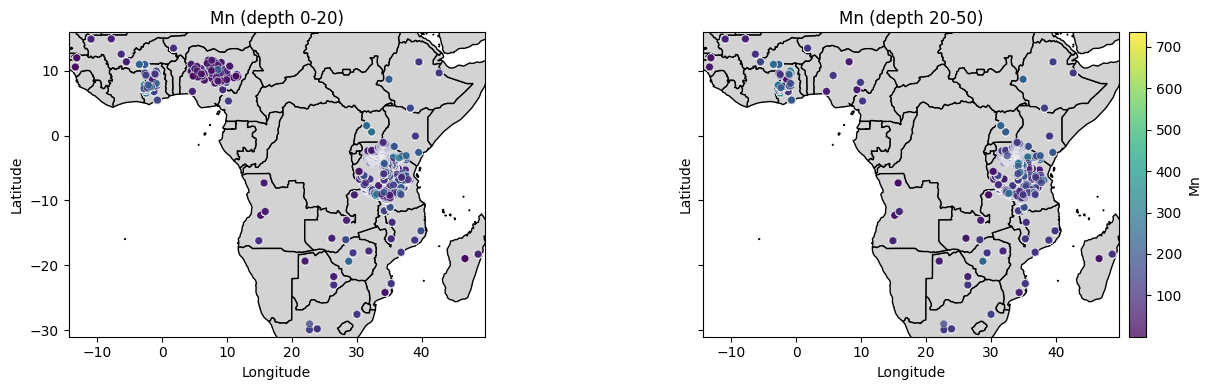

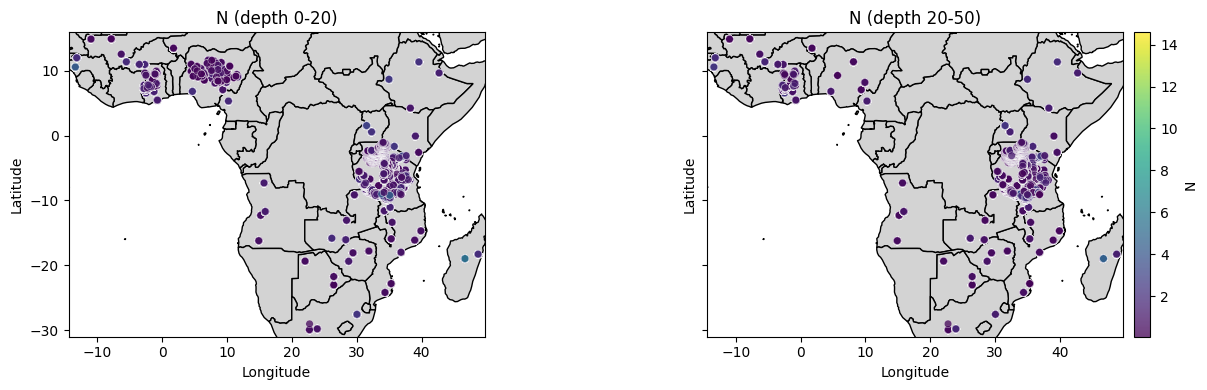

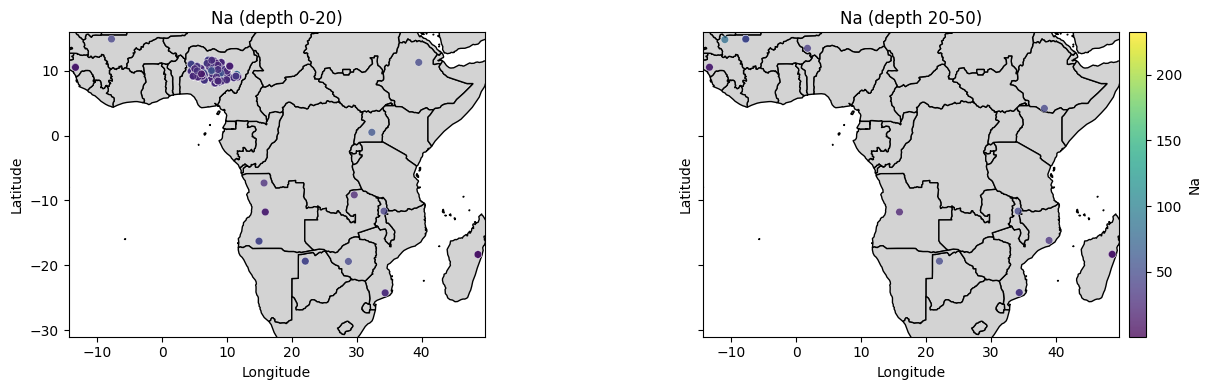

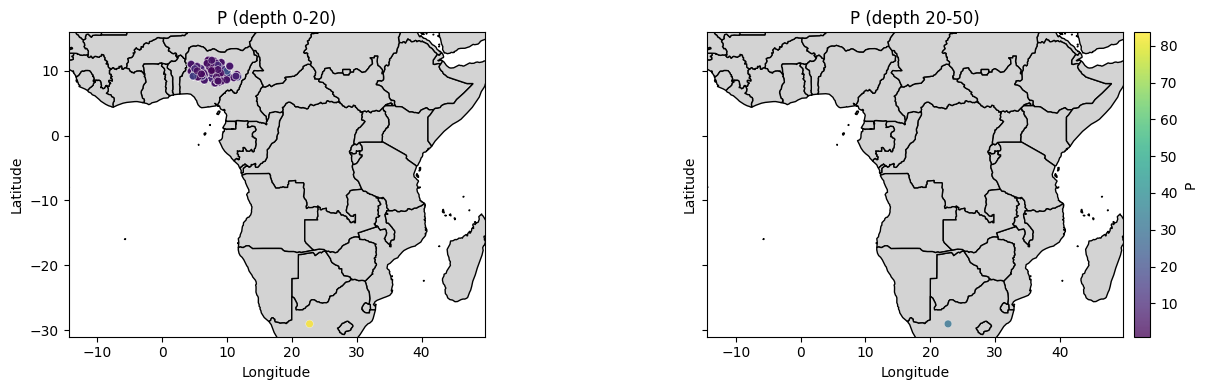

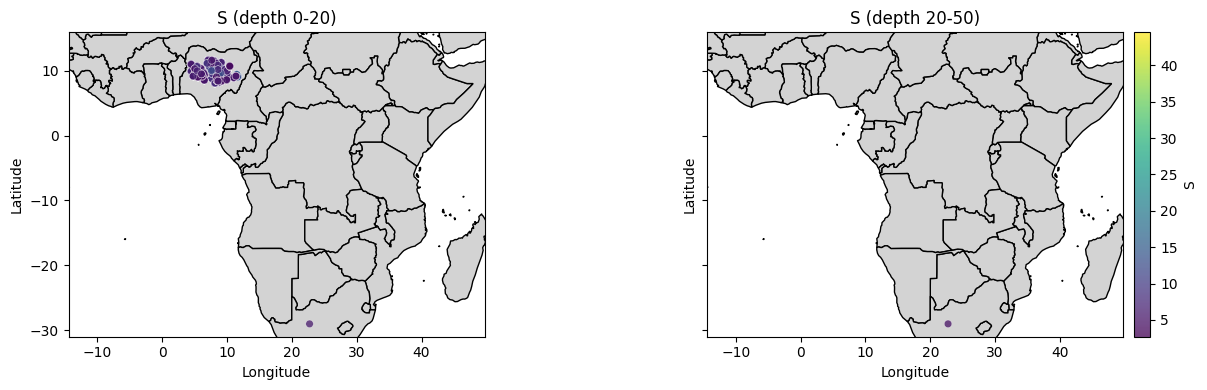

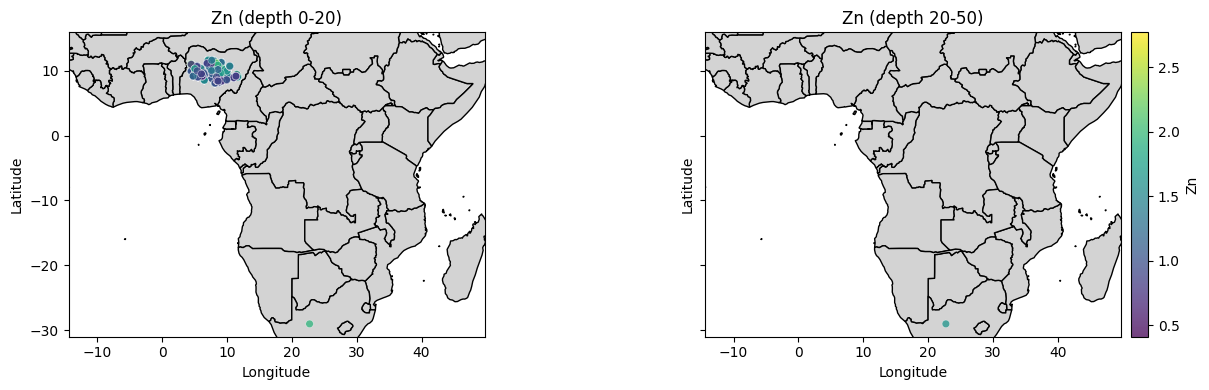

In [12]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

for target in TARGETS:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

    vmin = train_df[target].min(skipna=True)
    vmax = train_df[target].max(skipna=True)

    for ax, depth in zip(axes, ["0-20", "20-50"]):
        world_img.plot(ax=ax, color="lightgrey", edgecolor="black")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        d = train_df[train_df["Depth_cm"] == depth]

        sc = ax.scatter(
            d["Longitude"],
            d["Latitude"],
            s=30,
            alpha=0.75,
            c=d[target],
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            edgecolor="white",
            linewidth=0.3,
        )

        ax.set_title(f"{target} (depth {depth})")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    # --- colorbar outside the right panel ---
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="4%", pad=0.1)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(target)

    plt.tight_layout()
    plt.show()




## Naive nearest-neighbour predictor
Lets make our first submission by simply

In [14]:

train_df

,ID,Longitude,Latitude,start_date,end_date,horizon_lower,horizon_upper,Depth_cm,Al,B,...,Mn,N,ph,P,K,Na,S,Zn,dataset,distance
6124,XUUW3E,-1.05584,7.62942,01/01/2008,31/12/2018,50,20,20-50,1023.041,NaN,...,191.258,0.94,5.640,NaN,64.305,NaN,NaN,NaN,train,2.000000e-10
16303,RHSOGL,-1.05590,7.63114,01/01/2008,31/12/2018,20,0,0-20,279.597,NaN,...,44.642,0.30,6.512,NaN,55.456,NaN,NaN,NaN,train,1.515600e-06
6130,0T11ZY,-1.05594,7.63115,01/01/2008,31/12/2018,50,20,20-50,274.514,NaN,...,5.637,0.18,5.926,NaN,44.461,NaN,NaN,NaN,train,1.536250e-06
16290,9PSZTR,-1.05299,7.62773,01/01/2008,31/12/2018,20,0,0-20,312.942,NaN,...,69.246,0.32,6.371,NaN,64.882,NaN,NaN,NaN,train,5.455700e-06
6119,OCRGQF,-1.05298,7.62771,01/01/2008,31/12/2018,50,20,20-50,498.529,NaN,...,28.365,0.46,5.735,NaN,47.010,NaN,NaN,NaN,train,5.517850e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32422,S3USW8,48.76240,-18.33800,01/01/2008,31/12/2018,20,0,0-20,1232.049,NaN,...,4.217,3.01,4.600,NaN,67.585,NaN,NaN,NaN,train,1.578081e+03
21143,FZNZZO,48.76240,-18.33800,01/01/2008,31/12/2018,50,20,20-50,1280.829,NaN,...,15.614,2.29,4.610,NaN,51.207,NaN,NaN,NaN,train,1.578081e+03
21127,AEMT0S,48.76110,-18.34330,01/01/2008,31/12/2018,50,20,20-50,1060.343,NaN,...,11.414,1.60,4.689,NaN,36.643,NaN,NaN,NaN,train,1.578154e+03
21138,YSPU3F,48.76380,-18.33920,01/01/2008,31/12/2018,50,20,20-50,917.478,NaN,...,174.957,1.26,4.958,NaN,64.640,NaN,NaN,NaN,train,1.578182e+03


In [19]:

depth_mask_test

array([ True,  True,  True, ...,  True,  True,  True], shape=(6070,))

In [28]:
feature_cols = ["Longitude", "Latitude"]

X = train_df[feature_cols].values
y = train_df[TARGETS].copy()

# Fill missing target values
for target in TARGETS:
    mask_obs = y[target].notna()
    mask_miss = ~mask_obs

    if mask_miss.sum() == 0:
        continue  # nothing to fill

    knn = KNeighborsRegressor(n_neighbors=1, weights="distance")

    knn.fit(X[mask_obs], y.loc[mask_obs, target])
    y.loc[mask_miss, target] = knn.predict(X[mask_miss])

pred_ls = []
for depth in ["0-20", "20-50"]:

    depth_mask_train = train_df["Depth_cm"].values == depth
    depth_mask_test = test_df["Depth_cm"].values == depth

    X_train = train_df.loc[depth_mask_train, feature_cols]
    X_test = test_df.loc[depth_mask_test, feature_cols]

    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y[depth_mask_train])

    preds = knn_model.predict(X_test)
    pred_ls.append(preds)

preds = np.concat(pred_ls)
submission = pd.DataFrame(preds, columns=[f"Target_{t}" for t in TARGETS])
submission.insert(0, "ID", test_df["ID"].values)

os.makedirs("output", exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "naive_KNN.csv")
submission.sort_values("ID", inplace=True)
submission.to_csv(output_path, index=False)

print(f"Saved submission to {output_path} with shape {submission.shape}")


Saved submission to C:\Users\phili\Rhea-Soil-Nutrient-Prediction-Challenge\output\naive_KNN.csv with shape (6070, 14)
